In [157]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import json
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import PIL

## Import the emotional classification model

In [1]:
from transformers import pipeline
classifier = pipeline(model='bhadresh-savani/distilbert-base-uncased-emotion')




/Users/hakkam/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Using the BeautifulSoup scrapper to scrape the joker film script

In [3]:
result = requests.get("https://imsdb.com/scripts/Joker.html")

In [4]:
doc = BeautifulSoup(result.text, "html.parser")
script = doc.find("pre")

In [5]:
scenes = re.split("INT\.|EXT\.",script.text)

### Split the scenes into smaller chunks to input into the models

In [6]:
for scene in scenes:
    index = int(scenes.index(scene))
    scenes[index] = scene.replace('\n','').replace('\r','').replace('\t','')
    if len(scene.split()) > 512 and len(scene.split()) < 1024:
        length = len(scene)
        mid = length//2
        text1 = scene[:mid]
        text2 = scene[mid:]
        scenes[index] = text1
        scenes.insert(index+1, text2)
    if len(scene.split()) > 1024:
        length = len(scene)
        part = length//3
        text1 = scene[:part]
        text2 = scene[part:part*2]
        text3 = scene[part*2:]
        scenes[index] = text1
        scenes.insert(index+1, text2)
        scenes.insert(index+2, text3)

## Store the data in a json file

In [9]:
dict_list = [{"scene_no":index+1,"scene":scene} for index, scene in enumerate(scenes)]

In [11]:
json_data = json.dumps(dict_list, indent=4)

In [12]:
with open('joker_final.json', 'w') as f:
    f.write(json_data)

In [13]:
df = pd.read_json('joker_final.json')
df.head(5)

,scene_no,scene
0,1,JOKER ...
1,2,"DEPT. OF HEALTH, OFFICE - MORNING ..."
2,3,"JOKER Right.ANGLE ON JOURNAL, page..."
3,4,"GOTHAM SQUARE, MIDTOWN - KENNY'S MUSIC SHOP -..."
4,5,"CORNER, SIDE STREET - GOTHAM SQUARE - CONTINU..."


Strip the scenes off of white space characters

In [33]:
def strip(text):
    stripped_text = text.replace('\n','').replace('\r','').replace('\t','')
    return stripped_text

In [34]:
df['stripped_scene'] = df['scene'].apply(strip)

### Use the tokenizer to truncate the scenes to 512 tokens

In [62]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

## Function the classify the scenes into emotions

In [119]:
def classify(text):
    tokens = tokenizer(text)
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    if len(input_ids) > 505:
        input_ids = input_ids[-505:-1]

    text = tokenizer.decode(input_ids)
    emotion = classifier(text)[0]
    label = emotion['label']
    return label


        
        
    

In [120]:
df['emotion'] = df['stripped_scene'].apply(classify)

In [121]:
df['emotion']

0      sadness
1      sadness
2      sadness
3        anger
4        anger
        ...   
137       fear
138      anger
139       fear
140        joy
141        joy
Name: emotion, Length: 142, dtype: object

## Map the emotions into numbers

In [154]:
emotion_order = ['joy', 'love', 'surprise','sadness','anger', 'fear']
order = [6,5,4,3,2,1]
datamap = {x:y for x,y in zip(emotion_order,order)}
df['emotion_code'] = df['emotion'].map(datamap)


In [155]:
datamap

{'joy': 6, 'love': 5, 'surprise': 4, 'sadness': 3, 'anger': 2, 'fear': 1}

([<matplotlib.axis.YTick at 0x282add6c0>,
 [Text(0, 6, 'joy'),
  Text(0, 5, 'love'),
  Text(0, 4, 'surprise'),
  Text(0, 3, 'sadness'),
  Text(0, 2, 'anger'),
  Text(0, 1, 'fear')])

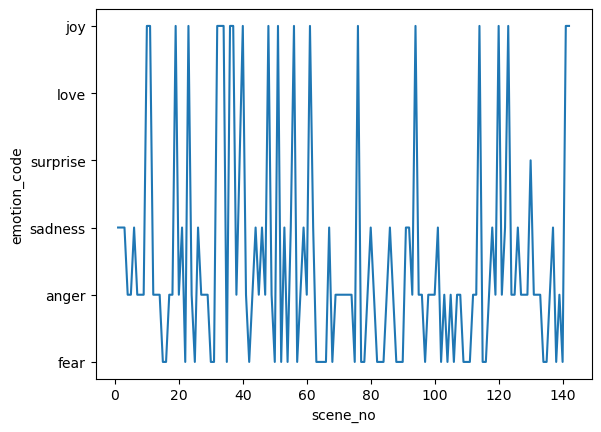

In [156]:
sns.lineplot(data=df,x='scene_no',y='emotion_code')
plt.yticks(order,emotion_order)

### Use the pillow library to represent the emotions using colours

In [159]:
from PIL import Image, ImageDraw

In [2]:
color_mapping = {
    'joy': (72, 143, 49),       
    'love': (198, 210, 119),     
    'surprise': (255, 246, 163),  
    'sadness':(248, 189, 110),    
    'anger': (236, 128, 83),     
    'fear': (222, 66, 91)	
}

In [192]:
# Define image dimensions and bar height
image_width = 1200
image_height = 500
bar_height = 500

# Create a blank image
image = Image.new('RGB', (image_width, image_height), 'white')
draw = ImageDraw.Draw(image)
length = df.shape[0]
# Draw colored bars based on emotions
for index, row in df.iterrows():
    scene_num = row['scene_no']
    emotion = row['emotion']
    color = color_mapping.get(emotion, (0, 0, 0))  # Default to black if emotion not found
    start_x = scene_num * round(image_width / length)
    end_x = (scene_num+1) * round(image_width / length)
    draw.rectangle([start_x, 0, end_x, bar_height], fill=color)

# Save the image
image.save('emotion_barcode.png')